<a href="https://colab.research.google.com/github/ElBarBary01/ArabicNER/blob/master/BERT_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Arabert Model to do NER Task

### Environment setup

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sun Feb  4 12:25:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

In [ ]:
!pip install transformers
!pip install pyarabic
!pip install seqeval
!git clone https://github.com/aub-mind/arabert
!git clone https://github.com/ElBarBary01/ArabicNER.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b5d6773be388a2eae0f984a3f7fc1e7fd44b32549356087273721b16cef0454b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 26.59 MiB/s, done.
Resolving deltas: 100% (339/339), done.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from  tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
from arabert.preprocess import ArabertPreprocessor
import numpy as np

from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer , TrainingArguments
from transformers.trainer_utils import EvaluationStrategy
from transformers.data.processors.utils import InputFeatures
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample
import logging
import torch
from torch import nn

%load_ext google.colab.data_table

## Preprocessing

In this part,  the dataset is converted to a list of sentences using the newline token to get the end of each sentence


This function will make a dataset of sentences

returns: list of shape:
  [no_sentences] *  [ [words] , [tags] ]

In [ ]:
def read_dataset(path):
  with open(path,'r',encoding='utf-8') as f:
    data = []
    sentence = []
    label = []
    for line in f:
      # line = line.replace(u'\u200e','')
      # line = line.replace(u'\ufeff','')
      if '[NEWLINE]' in line:
        if len(sentence) > 0:
          data.append([sentence,label])
          sentence = []
          label = []
        continue
      line = line.strip('\n')
      splits = line.split('\t')
      sentence.append(splits[0])
      label.append(splits[1])
    if len(sentence) > 0:
      data.append([sentence,label])
  return data

Here we can see after converting the dataset into sentences, that we have 15763 Sentence

In [ ]:

data = read_dataset('train_filter4.txt')
print(len(data))


16817


In [ ]:
df = pd.DataFrame(data, columns=['text', 'tags'])
df.head(1)


,text,tags
0,"[بين, الوعي, والّلاوعي, عم, شوف, حلم, وانا, عا...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


Get the list of all classes we have

In [ ]:
label_list = list(pd.read_csv('labels.txt', header=None, index_col=0).T)

label_map = { v:index for index, v in enumerate(label_list) }
inv_label_map = {i: label for i, label in enumerate(label_list)}

print(label_map)
print(inv_label_map)

{'O': 0, 'B-OCC': 1, 'I-OCC': 2, 'B-PERS': 3, 'I-PERS': 4, 'B-PRODUCT': 5, 'I-PRODUCT': 6, 'B-GPE': 7, 'I-GPE': 8, 'B-LOC': 9, 'I-LOC': 10, 'B-DATE': 11, 'I-DATE': 12, 'B-ORG': 13, 'I-ORG': 14, 'B-WEBSITE': 15, 'I-WEBSITE': 16}
{0: 'O', 1: 'B-OCC', 2: 'I-OCC', 3: 'B-PERS', 4: 'I-PERS', 5: 'B-PRODUCT', 6: 'I-PRODUCT', 7: 'B-GPE', 8: 'I-GPE', 9: 'B-LOC', 10: 'I-LOC', 11: 'B-DATE', 12: 'I-DATE', 13: 'B-ORG', 14: 'I-ORG', 15: 'B-WEBSITE', 16: 'I-WEBSITE'}


## Dataset splits


Split the Dataset into:  80% Train, 10% Valdiation, and 10% Test

In [ ]:
 train_data, test_data = train_test_split(data,test_size= 0.2)

 test_data , eval_data = train_test_split(test_data,test_size= 0.5)

In [ ]:
print(len(train_data))
print(len(test_data))
print(len(eval_data))

13453
1682
1682


Here we get the frequency of each class in dataset

In [ ]:
print(Counter([ label for sentence in train_data for label in sentence[1]]))
print(Counter([ label for sentence in test_data for label in sentence[1]]))



Counter({'O': 224151, 'I-DATE': 31346, 'I-ORG': 12627, 'B-ORG': 8633, 'B-DATE': 8569, 'I-OCC': 6476, 'B-GPE': 6428, 'I-GPE': 4385, 'I-PERS': 3735, 'B-PERS': 3632, 'B-OCC': 2970, 'I-WEBSITE': 1317, 'B-LOC': 388, 'I-LOC': 388, 'B-WEBSITE': 362, 'I-PRODUCT': 52, 'B-PRODUCT': 27})
Counter({'O': 27155, 'I-DATE': 3711, 'I-ORG': 1623, 'B-ORG': 1081, 'B-DATE': 1036, 'I-OCC': 826, 'B-GPE': 804, 'I-GPE': 606, 'I-PERS': 418, 'B-PERS': 410, 'B-OCC': 368, 'I-WEBSITE': 124, 'B-LOC': 53, 'I-LOC': 48, 'B-WEBSITE': 35, 'I-PRODUCT': 8, 'B-PRODUCT': 2})


Here we get a histogram of number of tokens in each sentence, to choose  a suitiable size for BERT MAX_LEN

Training Sentence Lengths: 


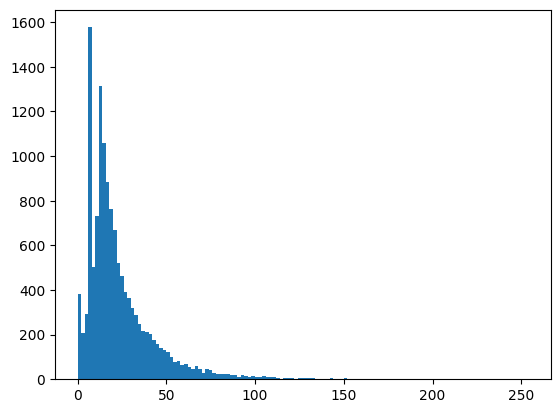

3
Testing Sentence Lengths: 


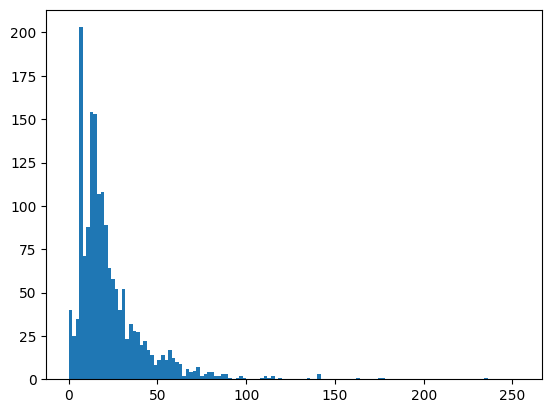

0


In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in train_data],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in train_data]))

print("Testing Sentence Lengths: ")
plt.hist([ len(sentence[0]) for sentence in test_data],bins=range(0,256,2))
plt.show()
print(sum([len(sentence[0]) > 256 for sentence in test_data]))

## Training


### Model Config

Here, we define some constants to use

In [ ]:
DATASET_NAME = 'Wojood'
MODEL_NAME = 'aubmindlab/bert-base-arabertv02'
TASK_NAME = 'tokenclassification'

MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
MODEL_PATH = "model"

TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

### Dataset


Here we define the Dataset class, and how to process batches before training


In [ ]:
class NERDataset:
  def __init__(self, texts, tags, label_list, model_name, max_length):
    self.texts = texts
    self.tags = tags
    self.label_map = {label: i for i, label in enumerate(label_list)}
    self.preprocessor = ArabertPreprocessor(model_name.split("/")[-1])
    self.pad_token_label_id = torch.nn.CrossEntropyLoss().ignore_index
    # Use cross entropy ignore_index as padding label id so that only
    # real label ids contribute to the loss later.
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_length = max_length


  def __len__(self):
    return len(self.texts)

  def __getitem__(self, item):
    textlist = self.texts[item]
    tags = self.tags[item]

    tokens = []
    label_ids = []
    for word, label in zip(textlist, tags):
      clean_word = self.preprocessor.preprocess(word)
      word_tokens = self.tokenizer.tokenize(clean_word)


      if len(word_tokens) > 0:
        tokens.extend(word_tokens)
        # Use the real label id for the first token of the word, and padding ids for the remaining tokens
        label_ids.extend([self.label_map[label]] + [self.pad_token_label_id] * (len(word_tokens) - 1))

    # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
    special_tokens_count = self.tokenizer.num_special_tokens_to_add()
    if len(tokens) > self.max_length - special_tokens_count:
      tokens = tokens[: (self.max_length - special_tokens_count)]
      label_ids = label_ids[: (self.max_length - special_tokens_count)]

    #Add the [SEP] token
    tokens += [self.tokenizer.sep_token]
    label_ids += [self.pad_token_label_id]
    token_type_ids = [0] * len(tokens)

    #Add the [CLS] TOKEN
    tokens = [self.tokenizer.cls_token] + tokens
    label_ids = [self.pad_token_label_id] + label_ids
    token_type_ids = [0] + token_type_ids

    input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1] * len(input_ids)


    # Zero-pad up to the sequence length.
    padding_length = self.max_length - len(input_ids)

    input_ids += [self.tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length
    token_type_ids += [0] * padding_length
    label_ids += [self.pad_token_label_id] * padding_length

    assert len(input_ids) == self.max_length
    assert len(attention_mask) == self.max_length
    assert len(token_type_ids) == self.max_length
    assert len(label_ids) == self.max_length

    # if item < 5:
    #   print("*** Example ***")
    #   print("tokens:", " ".join([str(x) for x in tokens]))
    #   print("input_ids:", " ".join([str(x) for x in input_ids]))
    #   print("attention_mask:", " ".join([str(x) for x in attention_mask]))
    #   print("token_type_ids:", " ".join([str(x) for x in token_type_ids]))
    #   print("label_ids:", " ".join([str(x) for x in label_ids]))

    return {
        'input_ids' : torch.tensor(input_ids, dtype=torch.long),
        'attention_mask' : torch.tensor(attention_mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
        'labels' : torch.tensor(label_ids, dtype=torch.long)
    }

Here we create The datasets for train,val, and test

In [ ]:


train_dataset = NERDataset(
    texts=[x[0] for x in train_data],
    tags=[x[1] for x in train_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

test_dataset = NERDataset(
    texts=[x[0] for x in test_data],
    tags=[x[1] for x in test_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

eval_dataset = NERDataset(
    texts=[x[0] for x in eval_data],
    tags=[x[1] for x in eval_data],
    label_list=label_list,
    model_name=MODEL_NAME,
    max_length=MAX_LEN
    )

### Model init and Data Loaders

Here we initalize the model as a Bert model for token classification

In [ ]:

def model_init():
    return BertForTokenClassification.from_pretrained(MODEL_NAME,
                                                      return_dict=True,
                                                      num_labels=len(label_map),output_attentions = False,
                                                      output_hidden_states = False)





In [ ]:
my_model = model_init()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(my_model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
train_data_loader = DataLoader(dataset=train_dataset,batch_size=TRAIN_BATCH_SIZE,shuffle= True)
eval_data_loader = DataLoader(dataset=eval_dataset,batch_size=VALID_BATCH_SIZE,shuffle= True)
test_data_loader = DataLoader(dataset=test_dataset,batch_size=TEST_BATCH_SIZE,shuffle= True)

### Train, Eval, Test Functions

#### Helper Funvtions

In [ ]:

def align_predictions(predictions, label_ids):
    """
        Takes batch of senteces, and the logits for every word in every sentences
        it will exclude the padding tokens

        predictions:  [ [ [logits] ] ]
        label_ids: [[Sentence1], [Sentence2]]

        returns : predicition label list of shape (no_sentences, no_words_in_sentece)
                  true label list of shape (no_sentences, no_words_in_sentece)

                  output example: y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
                                  y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
    """

    preds = np.argmax(predictions, axis=2)



    batch_size, seq_len = preds.shape

    assert(preds.shape == label_ids.shape)

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):

            if label_ids[i] [j] != torch.nn.CrossEntropyLoss().ignore_index:

                out_label_list[i].append(inv_label_map[label_ids[i][j]])
                preds_list[i].append(inv_label_map[preds[i][j]])

    return preds_list, out_label_list

In [ ]:
target_names=list(label_map.keys())
# target_names = target_names[1:]
print(target_names)

['O', 'B-OCC', 'I-OCC', 'B-PERS', 'I-PERS', 'B-PRODUCT', 'I-PRODUCT', 'B-GPE', 'I-GPE', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE', 'B-ORG', 'I-ORG', 'B-WEBSITE', 'I-WEBSITE']


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


def compute_metrics(predictions, labels, generate_report=True):
    preds_list, out_label_list = align_predictions(predictions, labels)

    mlb = MultiLabelBinarizer()
    binarized_labels = mlb.fit_transform(out_label_list)
    binarized_preds = mlb.transform(preds_list)


    # Replace indices with entity names
    if generate_report:
        try:
            print(classification_report(binarized_labels, binarized_preds, target_names=target_names))
        except Exception as e:
            print(f'There was an error while generating the classification report: {e}')


    return {
        "accuracy_score": accuracy_score(out_label_list, preds_list),
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list),
    }


#### Train Function

In [ ]:
def train_epoch(train_dl, model, optimizer,scheduler,device):

    ###########################################
    #                                         #
    #           TRAINING STARTS HERE          #
    #                                         #
    ###########################################

    model.train()

    final_loss = 0

    i = 0

    for data in tqdm(train_dl, total = len(train_dl)):

        # BATCH

        # Send Data to GPU
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['labels'].to(device)


        optimizer.zero_grad()



        # we can also pass token_type_ids

        outputs = model(input_ids = input_ids,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        labels=labels)

        #### For watching training
        # if i==2:
        #     a= []
        #     b = []
        #     print(outputs.logits[5].shape)
        #     print(labels[5].shape)
        #     for word in outputs.logits[5]:
        #         a.append(np.argmax(word.to('cpu').detach().numpy()))
        #     for l in labels[5]:
        #         b.append(l)
        #     print(len(a), len(b))
        #     print  ( ' CORRECT:  ',torch.sum(torch.tensor(a) == torch.tensor(b)) )
        #     for aa,bb in zip(a,b):
        #         print(f' predicted : {aa} ,   Label:  {bb}')

        # i+=1

        #print(outputs)


        loss = outputs.loss

        loss.backward()


        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        final_loss += loss.item()



    print(final_loss)

    return final_loss / len(train_dl)

#### Validation Function

In [ ]:
def eval_epoch(eval_dl, model,device, generate_report = False):

  ###########################################
  #                                         #
  #           EVALUATION STARTS HERE        #
  #                                         #
  ###########################################

    model.eval()

    final_loss = 0

    # 3D array to store every sentence and its logits (2D array)
    all_preds = []

    # 2D array to store every sentence and its labels
    all_labels = []

    for data in tqdm(eval_dl, total = len(eval_dl)):

        # BATCH

        # Send Data to GPU
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['labels'].to(device)



        outputs = model(input_ids = input_ids,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        labels=labels)


        loss = outputs[0]

        final_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()




        all_preds.extend(logits)
        all_labels.extend(labels)



    all_preds = np.array(all_preds)
    all_labels = np.asarray(all_labels)



    # this will first clean the data from the padding tokens, then will calcuate the metrics
    metrics = compute_metrics(all_preds, all_labels, generate_report)


    final_loss = final_loss / len(eval_dl)



    return final_loss, metrics

#### Test Function

In [ ]:
def model_test(test_dl,model,device):

    ###########################################
    #                                         #
    #           TEST STARTS HERE              #
    #                                         #
    ###########################################
    with torch.no_grad():
        model.to(device)
        model.eval()
        final_loss = 0
        all_predictions = []
        all_labels = []
        for data in tqdm(test_dl, total = len(test_dl)):

            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            labels = data['labels'].to(device)



            outputs = model(input_ids = input_ids,
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels)


            loss = outputs.loss

            predictions = outputs.logits

            all_labels.extend(labels.to('cpu').numpy())
            all_predictions.extend(outputs.logits.to('cpu').numpy())

            final_loss += loss.item()

            #print(np.array(all_predictions).shape)

            # all_labels=  torch.tensor(all_labels).to('cpu').numpy()
            # all_predictions = torch.tensor(all_predictions).to('cpu').numpy()



        metrics = \
        compute_metrics(predictions=np.asarray(all_predictions), labels=np.asarray(all_labels))

        accuracy_score = metrics['accuracy_score']
        precision= metrics['precision']
        recall= metrics['recall']
        f1= metrics['f1']

        print(f' Accuracy: {accuracy_score}')
        print(f' Precision: {precision}')
        print(f' Recall: {recall}')
        print(f' F1: {f1}')


        final_loss /= len(test_dl)

        print(f'Final Test Loss is: {final_loss}' )


### Train Loop

This part is in case we wann continue from a  trined model, so we load the state dict and continue upon it

In [ ]:


# ! cp drive/MyDrive/Models/model_v1 .

model = model_init().to(device)
# model.load_state_dict(torch.load('model_v1', map_location='cpu'))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Here we configure an optimizer and a scheduler

In [ ]:
from torch.optim import Adamax

optimizer = Adamax(model.parameters(), lr=5e-5, betas=(0.9, 0.999), weight_decay=0)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#### Train Loop

In [ ]:
for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)


    train_loss = train_epoch(
                            model = model,
                            train_dl = train_data_loader ,
                            device = device,
                            optimizer =optimizer,
                            scheduler = scheduler,

    )
    print(f'Train loss {train_loss}')


    eval_loss, metrics = eval_epoch(
                                model = model,
                                eval_dl = eval_data_loader ,
                                device = device,
                                generate_report = True
    )

    print(f'Eval loss: {eval_loss}')
    print(f'Eval Metrics:  {metrics}')
    print('--------------------------------------------------------------------')

Epoch 1/10
----------


  0%|          | 0/841 [00:00<?, ?it/s]

125.39581711869687
Train loss 0.14910323081890234


  0%|          | 0/106 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           O       0.98      0.99      0.99       967
       B-OCC       0.94      0.94      0.94       593
       I-OCC       0.82      0.76      0.79        54
      B-PERS       0.95      0.97      0.96       302
      I-PERS       0.96      0.97      0.96       782
   B-PRODUCT       0.96      0.97      0.97       377
   I-PRODUCT       0.00      0.00      0.00         5
       B-GPE       0.70      0.62      0.65        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.92      0.95      0.93       352
       I-LOC       0.81      0.81      0.81        42
      B-DATE       0.98      0.98      0.98       248
      I-DATE       0.97      0.97      0.97       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       0.00      0.00      0.00         5
   B-WEBSITE       0.80      0.57      0.67        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.97   

  0%|          | 0/841 [00:00<?, ?it/s]

53.21519100293517
Train loss 0.06327608918303826


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.96      0.95      0.95       593
       I-OCC       0.90      0.83      0.87        54
      B-PERS       0.97      0.96      0.97       302
      I-PERS       0.96      0.97      0.97       782
   B-PRODUCT       0.96      0.98      0.97       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.73      0.73      0.73        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.94      0.94      0.94       352
       I-LOC       0.84      0.88      0.86        42
      B-DATE       0.98      0.99      0.98       248
      I-DATE       0.96      0.98      0.97       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.86      0.86      0.86        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

40.04129364620894
Train loss 0.047611526333185425


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.96      0.97      0.96       593
       I-OCC       0.88      0.83      0.86        54
      B-PERS       0.98      0.96      0.97       302
      I-PERS       0.98      0.95      0.96       782
   B-PRODUCT       0.97      0.97      0.97       377
   I-PRODUCT       1.00      0.20      0.33         5
       B-GPE       0.77      0.77      0.77        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.95      0.95      0.95       352
       I-LOC       0.84      0.86      0.85        42
      B-DATE       0.98      0.99      0.98       248
      I-DATE       0.98      0.98      0.98       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.86      0.86      0.86        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

29.850890263798647
Train loss 0.03549451874411254


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.95      0.96      0.95       593
       I-OCC       0.84      0.85      0.84        54
      B-PERS       0.97      0.97      0.97       302
      I-PERS       0.97      0.97      0.97       782
   B-PRODUCT       0.97      0.97      0.97       377
   I-PRODUCT       1.00      0.60      0.75         5
       B-GPE       0.81      0.81      0.81        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.94      0.96      0.95       352
       I-LOC       0.78      0.90      0.84        42
      B-DATE       0.97      0.99      0.98       248
      I-DATE       0.96      0.98      0.97       709
       B-ORG       0.99      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.79      0.79      0.79        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

23.385710965609178
Train loss 0.027807028496562636


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.95      0.97      0.96       593
       I-OCC       0.82      0.87      0.85        54
      B-PERS       0.97      0.96      0.97       302
      I-PERS       0.97      0.98      0.97       782
   B-PRODUCT       0.97      0.97      0.97       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.82      0.88      0.85        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.94      0.96      0.95       352
       I-LOC       0.84      0.88      0.86        42
      B-DATE       0.97      0.99      0.98       248
      I-DATE       0.97      0.98      0.97       709
       B-ORG       0.99      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.79      0.79      0.79        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

18.50957518594805
Train loss 0.02200900735546736


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.98      1.00      0.99       967
       B-OCC       0.95      0.97      0.96       593
       I-OCC       0.82      0.91      0.86        54
      B-PERS       0.97      0.98      0.97       302
      I-PERS       0.97      0.98      0.98       782
   B-PRODUCT       0.97      0.98      0.97       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.75      0.92      0.83        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.94      0.96      0.95       352
       I-LOC       0.77      0.88      0.82        42
      B-DATE       0.96      0.99      0.98       248
      I-DATE       0.97      0.98      0.98       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.80      0.86      0.83        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

15.379542860318907
Train loss 0.018287209108583717


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.96      0.95      0.96       593
       I-OCC       0.84      0.85      0.84        54
      B-PERS       0.97      0.98      0.98       302
      I-PERS       0.97      0.97      0.97       782
   B-PRODUCT       0.97      0.98      0.97       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.80      0.92      0.86        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.96      0.95      0.96       352
       I-LOC       0.82      0.88      0.85        42
      B-DATE       0.96      0.99      0.98       248
      I-DATE       0.98      0.98      0.98       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.80      0.86      0.83        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

13.083916061266791
Train loss 0.015557569632897492


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.96      0.96      0.96       593
       I-OCC       0.85      0.85      0.85        54
      B-PERS       0.97      0.98      0.98       302
      I-PERS       0.97      0.97      0.97       782
   B-PRODUCT       0.97      0.98      0.97       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.77      0.92      0.84        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.95      0.95      0.95       352
       I-LOC       0.82      0.88      0.85        42
      B-DATE       0.97      0.99      0.98       248
      I-DATE       0.97      0.98      0.98       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.80      0.86      0.83        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

11.227235767233651
Train loss 0.013349864170313497


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.96      0.95      0.96       593
       I-OCC       0.85      0.85      0.85        54
      B-PERS       0.97      0.98      0.98       302
      I-PERS       0.97      0.97      0.97       782
   B-PRODUCT       0.97      0.98      0.97       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.77      0.92      0.84        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.95      0.95      0.95       352
       I-LOC       0.77      0.88      0.82        42
      B-DATE       0.97      0.99      0.98       248
      I-DATE       0.97      0.98      0.97       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.80      0.86      0.83        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

  0%|          | 0/841 [00:00<?, ?it/s]

10.481596497935243
Train loss 0.012463253861991966


  0%|          | 0/106 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           O       0.99      0.99      0.99       967
       B-OCC       0.96      0.95      0.96       593
       I-OCC       0.84      0.85      0.84        54
      B-PERS       0.97      0.98      0.98       302
      I-PERS       0.97      0.97      0.97       782
   B-PRODUCT       0.97      0.98      0.98       377
   I-PRODUCT       1.00      0.80      0.89         5
       B-GPE       0.77      0.92      0.84        26
       I-GPE       0.99      1.00      0.99       841
       B-LOC       0.94      0.95      0.95       352
       I-LOC       0.79      0.88      0.83        42
      B-DATE       0.97      0.99      0.98       248
      I-DATE       0.97      0.98      0.97       709
       B-ORG       0.98      0.99      0.99       303
       I-ORG       1.00      0.80      0.89         5
   B-WEBSITE       0.80      0.86      0.83        14
   I-WEBSITE       1.00      1.00      1.00      1680

   micro avg       0.98   

### Saving Model

### Testing

In [ ]:
############ TESTING ###########


# test_model = model_init()
# test_model.load_state_dict(torch.load('model_v1', map_location='cpu'))

test_model = torch.load('BERT model' ,map_location='cpu')

model_test(test_dl= test_data_loader,model=test_model, device= device)

  0%|          | 0/106 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           O       0.99      0.99      0.99       961
       B-OCC       0.95      0.94      0.95       575
       I-OCC       0.81      0.87      0.84        39
      B-PERS       0.97      0.97      0.97       271
      I-PERS       0.96      0.98      0.97       823
   B-PRODUCT       0.95      0.99      0.97       340
   I-PRODUCT       0.00      0.00      0.00         2
       B-GPE       0.77      0.87      0.82        31
       I-GPE       0.99      0.99      0.99       814
       B-LOC       0.95      0.95      0.95       355
       I-LOC       0.84      0.93      0.89        29
      B-DATE       0.98      0.98      0.98       226
      I-DATE       0.96      0.98      0.97       779
       B-ORG       0.97      0.99      0.98       262
       I-ORG       1.00      1.00      1.00         2
   B-WEBSITE       0.83      0.83      0.83        18
   I-WEBSITE       1.00      1.00      1.00      1681

   micro avg       0.97   

 BEST Testing result


Accuracy: 0.9967066235732112
 Precision: 0.9761073825503356
 Recall: 0.9811117107393416
 F1: 0.9786031489705288
Final Test Loss is: 0.018308890143107603

### Test on one sentence

This function is to test our trained model, on a sentence

In [ ]:
def predict_sent(sentences):

    input_ids  = TOKENIZER.encode(sentences, return_tensors='pt')

    #print(input_ids)

    with torch.no_grad():
        test_model.to('cpu')
        output = test_model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    #print(label_indices)

    tokens = TOKENIZER.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])


    # for a,b in zip(tokens, label_indices[0]):
    #     print(a , inv_label_map[b])


    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(inv_label_map[label_idx])
            new_tokens.append(token)


    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))

In [ ]:

sentences = " النجم محمد صلاح لاعب المنتخب المصري يعيش في مصر بالتحديد من الغربية"

predict_sent(sentences)